## Image classfication using CNN model
#### Dataset: [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
#### Framework: Pytorch

In [3]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from random import randrange
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
%matplotlib inline

In [4]:
#defining the model to be used
#6 CNN & 3 fully-connected layers
class CustomModel(nn.Module):
    def __init__(self, f1):
        super().__init__()
        self.f1 = f1
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
    
    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = self.f1.accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [5]:
class DeviceDataLoader():
    def __init__(self, f1, dl, device):
        self.dl = dl
        self.device = device
        self.f1 = f1
        
    def __iter__(self):
        for b in self.dl: 
            yield self.f1.to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [7]:
class CNN():
    def __init__(self):
        print("constructor")
        
    #initialize hyperparameters
    def init_hyp(self):
        self.batch_size = 128
        self.lr = 0.0001
        self.epoch = 20
    
    #get data in torch tensor
    def get_data(self):
        self.Dataset = CIFAR10
        self.dataset = self.Dataset(root='data/', train=True, transform=transforms.ToTensor(), download=True)
        self.input_size = np.prod(self.dataset[0][0].shape)
        self.num_classes = len(self.dataset.classes)
        
    #initialize data & make torch tensors
    def init_data(self):
        self.get_data()
        self.init_hyp()
        self.model = CustomModel(self)
        self.device = self.get_default_device()
        self.to_device(self.model, self.device)
        
        train_ds, val_ds = random_split(self.dataset, [int(len(self.dataset)*0.8), int(len(self.dataset)*0.2)])
        self.test_ds = self.Dataset(root='data/', train=False, transform=transforms.ToTensor())

        self.train_loader_cpu = DataLoader(train_ds, self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_ds, self.batch_size*2)
        self.test_loader = DataLoader(self.test_ds, self.batch_size*2)
        
        self.train_loader = DeviceDataLoader(self, self.train_loader_cpu, self.device)
        self.val_loader = DeviceDataLoader(self, self.val_loader, self.device)
        self.test_loader = DeviceDataLoader(self, self.test_loader, self.device)
        
    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    @torch.no_grad()
    def evaluate(self, data):
        self.model.eval()
        outputs = [self.model.validation_step(batch) for batch in data]
        return self.model.validation_epoch_end(outputs)
    
    def display_batch(self):
        for images, _ in self.train_loader_cpu:
            print('images.shape:', images.shape)
            plt.figure(figsize=(16,8))
            plt.axis('off')
            plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
            break

    #train the model on train data
    def fit(self, opt_func=torch.optim.Adam):
        self.history = []
        optimizer = opt_func(self.model.parameters(), self.lr)
        for e in range(self.epoch):
            self.model.train()
            train_losses = []
            for batch in self.train_loader:
                loss = self.model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # Validation phase
            result = self.evaluate(self.val_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            self.model.epoch_end(e, result)
            self.history.append(result)
            
    def plot_acc(self):
        accuracies = [r['val_acc'] for r in self.history]
        plt.plot(accuracies, '-x')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('Accuracy vs. No. of epochs')
        
    def plot_loss(self):
        losses = [r['val_loss'] for r in self.history]
        plt.plot(losses, '-x')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Loss vs. No. of epochs');
        
    #predict random image from test dataset
    def predict_rand_image(self):
        img_i = randrange(0, len(self.test_ds), 1)
        img, label = self.test_ds[img_i]
        print(img.shape)
        plt.imshow(img.permute(1, 2, 0))
        print('Label:', self.test_ds.classes[label], ', Predicted:', self.test_ds.classes[self.predict_image(img)])
        
    def predict_image(self,img):
        xb = self.to_device(img.unsqueeze(0), self.device)
        yb = self.model(xb)
        _, preds  = torch.max(yb, dim=1)
        return preds[0].item()
    
    def get_default_device(self):
        if torch.cuda.is_available():
            return torch.device('cuda')
        else:
            return torch.device('cpu')
    
    def to_device(self, data, device):
        if isinstance(data, (list,tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)

In [8]:
f1 = CNN()

constructor


In [9]:
f1.init_data()

Files already downloaded and verified


In [10]:
f1.get_default_device()

device(type='cuda')

images.shape: torch.Size([128, 3, 32, 32])


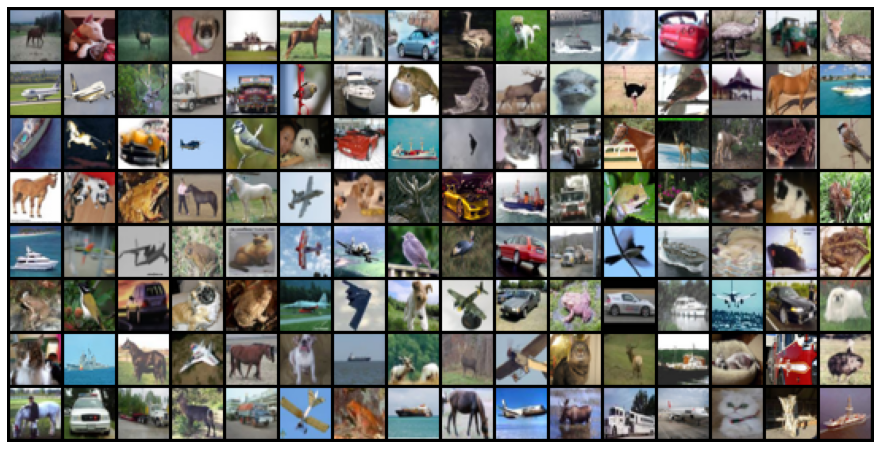

In [11]:
f1.display_batch()

In [12]:
f1.evaluate(f1.test_loader)

{'val_loss': 2.302886724472046, 'val_acc': 0.09765625}

In [13]:
f1.fit()

Epoch [0], val_loss: 1.8097, val_acc: 0.3333
Epoch [1], val_loss: 1.5431, val_acc: 0.4268
Epoch [2], val_loss: 1.4275, val_acc: 0.4852
Epoch [3], val_loss: 1.3553, val_acc: 0.5092
Epoch [4], val_loss: 1.2631, val_acc: 0.5354
Epoch [5], val_loss: 1.1654, val_acc: 0.5832
Epoch [6], val_loss: 1.1040, val_acc: 0.6083
Epoch [7], val_loss: 1.0497, val_acc: 0.6214
Epoch [8], val_loss: 1.0585, val_acc: 0.6266
Epoch [9], val_loss: 0.9738, val_acc: 0.6549
Epoch [10], val_loss: 0.9399, val_acc: 0.6692
Epoch [11], val_loss: 0.9236, val_acc: 0.6732
Epoch [12], val_loss: 0.9074, val_acc: 0.6774
Epoch [13], val_loss: 0.8582, val_acc: 0.6947
Epoch [14], val_loss: 0.8429, val_acc: 0.7015
Epoch [15], val_loss: 0.8140, val_acc: 0.7146
Epoch [16], val_loss: 0.8429, val_acc: 0.7116
Epoch [17], val_loss: 0.8270, val_acc: 0.7214
Epoch [18], val_loss: 0.8157, val_acc: 0.7263
Epoch [19], val_loss: 0.8229, val_acc: 0.7275


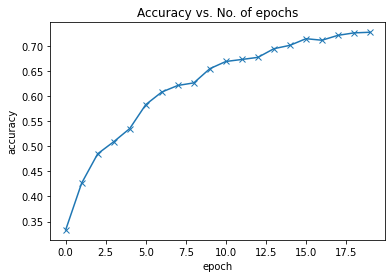

In [15]:
f1.plot_acc()

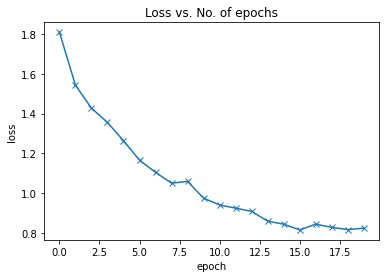

In [16]:
f1.plot_loss()

In [17]:
f1.evaluate(f1.test_loader)

{'val_loss': 0.8218891024589539, 'val_acc': 0.724316418170929}

torch.Size([3, 32, 32])
Label: frog , Predicted: frog


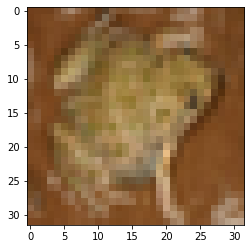

In [18]:
f1.predict_rand_image()